In [2]:
import sys
import os
import spams
import numpy as np
import math
from sklearn import preprocessing
from multiprocessing import Pool
from functools import partial
import signal

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)


import glob
import sys





import numpy as np
import time
import cv2
import openslide
import pyvips
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)

In [3]:
def definePar(nstains,lamb,batch=None):

	param={}	
	#param['mode']=2               #solves for =min_{D in C} (1/n) sum_{i=1}^n (1/2)||x_i-Dalpha_i||_2^2 + ... 
								   #lambda||alpha_i||_1 + lambda_2||alpha_i||_2^2
	param['lambda1']=lamb
	#param['lambda2']=0.05
	param['posAlpha']=True         #positive stains 
	param['posD']=True             #positive staining matrix
	param['modeD']=0               #{W in Real^{m x n}  s.t.  for all j,  ||d_j||_2^2 <= 1 }
	param['whiten']=False          #Do not whiten the data                      
	param['K']=nstains             #No. of stain = 2
	param['numThreads']=-1         #number of threads
	param['iter']=40               #20-50 is OK
	param['clean']=True
	if batch is not None:
		param['batchsize']=batch   #Give here input image no of pixels for traditional dictionary learning
	return param

In [4]:
def patch_Valid(patch,threshold):
	r_th=220
	g_th=220
	b_th=220
	tempr = patch[:,:,0]>r_th
	tempg = patch[:,:,1]>g_th
	tempb = patch[:,:,2]>b_th
	temp = tempr*tempg*tempb
	r,c = np.shape((temp)) 
	prob= float(np.sum(temp))/float((r*c))
	#print prob
	if prob>threshold:
		return False
	else:
		return True  

In [5]:
def suppress_stdout(out=None):
	if out is None:
		devnull = open('/dev/null', 'w')
		oldstdout_fno = os.dup(sys.stdout.fileno())
		os.dup2(devnull.fileno(), 1)
		return oldstdout_fno
	else:
		os.dup2(out, 1)

In [6]:
def vectorise(I):
	s=I.shape
	if len(s)==2: #case for 2D array
		third_dim=1
	else:
		third_dim=s[2] 
	return np.reshape(I, (s[0]*s[1],third_dim))

In [7]:
def initializer():
    """Ignore CTRL+C in the worker process."""
    signal.signal(signal.SIGINT, signal.SIG_IGN)

In [8]:
def BLtrans(Ivecd,i_0):
	Ivecd = vectorise(Ivecd)
	V=np.log(i_0)- np.log(Ivecd+1.0)
	w_threshold=220
	c = (Ivecd[:,0]<w_threshold) * (Ivecd[:,1]<w_threshold) * (Ivecd[:,2]<w_threshold)
	Ivecd=Ivecd[c]
	VforW=np.log(i_0)- np.log(Ivecd+1.0) #V=WH, +1 is to avoid divide by zero
	#shape of V = no. of pixels x 3 
	return V,VforW

In [9]:
def getstainMat(I,param,i_0):
	#I : Patch for W estimation
	V,VforW=BLtrans(I,i_0)   #Beer-Lambert law
	#step 2: Sparse NMF factorization (Learning W; V=WH)
	out = suppress_stdout()
	Ws = spams.trainDL(np.asfortranarray(np.transpose(VforW)),**param)
	suppress_stdout(out)
	return Ws

In [10]:
def W_sort(W):
	# All sorting done such that first column is H, second column is E
	# print W

	method = 3

	if method==1:
		# 1. Using r values of the vectors. E must have a smaller value of r (as it is redder) than H
		W = W[:,np.flipud(W[0,:].argsort())]
	elif method==2:
		# 2. Using b values of the vectors. H must have a smaller value of b (as it is bluer) than E
		W = W[:,W[2,:].argsort()]
	elif method==3:
		# 3. Using r/b ratios of the vectors. H must have a larger value of r/b.
		r_b_1 = W[0][0]/W[2][0]
		r_b_2 = W[0][1]/W[2][1]
		# print r_b_1, r_b_2
		if r_b_1<r_b_2: #else no need to switch
			W[:,[0, 1]] = W[:,[1, 0]]
	elif method==4:
		# 4. Using r-b values of the vectors. H must have a larger value of r-b.
		# This is equivalent to comparing the ratios of e^(-r)/e^(-b)
		r_b_1 = W[0][0]-W[2][0]
		r_b_2 = W[0][1]-W[2][1]
		# print r_b_1, r_b_2
		if r_b_1<r_b_2: #else no need to switch
			Wsource[:,[0, 1]] = Wsource[:,[1, 0]]

	return W

In [11]:
def normalize_W(W,k):
	W1 = preprocessing.normalize(W, axis=0, norm='l2')
	return W1

In [12]:
def Wfast(img,nstains,lamb,num_patches,patchsize,level,background_correction=False):
	
	param=definePar(nstains,lamb)
	_max=3000
	max_size=_max*_max
	xdim,ydim=img.level_dimensions[0]
	patchsize=int(min(patchsize,xdim/3,ydim/3))
	patchsize_original=patchsize
	nstains=param['K']
	valid_inp=[]
	
	white_pixels=[]

	#100,000 pixels or 20% of total pixels is maximum number of white pixels sampled
	max_num_white=min(100000,(xdim*ydim)/5)
	min_num_white=10000

	white_cutoff=220
	I_percentile=90

	if ydim*xdim>max_size:
		print ("Finding patches for W estimation:")
		for j in range(20):
			#print "Patch Sampling Attempt:",i+1
			initBias=int(math.ceil(patchsize/2)+1) 
			xx=np.array(range(initBias,xdim-initBias,patchsize))
			yy=np.array(range(initBias,ydim-initBias,patchsize))
			xx_yy=np.transpose([np.tile(xx, len(yy)), np.repeat(yy, len(xx))])
			np.random.shuffle(xx_yy)

			threshold=0.1 #maximum percentage of white pixels in patch
			for i in range(len(xx_yy)):
				patch=np.asarray(img.read_region((xx_yy[i][0],xx_yy[i][1]),level,(patchsize,patchsize)))
				patch=patch[:,:,:3]
				if len(white_pixels)<max_num_white:
					white_pixels.extend(patch[np.sum((patch>white_cutoff),axis=2)==3])

				if patch_Valid(patch,threshold):
					valid_inp.append(patch)
					if len(valid_inp)==num_patches:
						break

			if len(valid_inp)==num_patches:
				white_pixels=np.array(white_pixels[:max_num_white])
				break																																																																																																																																	
			patchsize=int(patchsize*0.95)
		valid_inp=np.array(valid_inp)
		print ("Number of patches sampled for W estimation:", len(valid_inp))
	else:
		patch=np.asarray(img.read_region((0,0),level,(xdim,ydim)))
		patch=patch[:,:,:3]
		valid_inp=[]
		valid_inp.append(patch)
		white_pixels= patch[np.sum((patch>white_cutoff),axis=2)==3]
		print ("Image small enough...W estimation done using whole image")

	if background_correction:
		print ("Number of white pixels sampled",len(white_pixels))
		if len(white_pixels)<min_num_white:
			i0=np.array([255.0,255.0,255.0])
			print ("Not enough white pixels found, default background intensity assumed")
		elif len(white_pixels)>0:
			i0 = np.percentile(white_pixels,I_percentile,axis=0)[:3]
		else:
			i0 = None
	else:
		i0 = np.array([255.0,255.0,255.0])

	if len(valid_inp)>0:
		out = suppress_stdout()
		pool = Pool(initializer=initializer)
		try:
		    WS = pool.map(partial(getstainMat,param=param,i_0=i0),valid_inp)
		except KeyboardInterrupt:
			pool.terminate()
			pool.join()
		pool.terminate()
		pool.join()
		suppress_stdout(out)

		WS=np.array(WS)
		# Ensure stain columns are sorted correct before taking median
		for i in range(len(WS)):
			WS[i] = W_sort(WS[i])

		if WS.shape[0]==1:
			Wsource=WS[0,:3,:]
		else:
			print ("Median color basis of",len(WS),"patches used as actual color basis")
			Wsource=np.zeros((3,nstains))
			for k in range(nstains):
			    Wsource[:,k]=[np.median(WS[:,0,k]),np.median(WS[:,1,k]),np.median(WS[:,2,k])]
		
		Wsource = W_sort(normalize_W(Wsource,nstains))

		if Wsource.sum()==0:
			if patchsize*0.95<100:
				print ("No suitable patches found for learning W. Please relax constraints")
				return None			#to prevent infinite recursion
			else:
				print ("W estimation failed, matrix of all zeros found. Trying again...")				
				return Wfast(img,nstains,lamb,min(100,num_patches*1.5),int(patchsize_original*0.95),level)
		else:
			return Wsource,i0
	else:
		print ("No suitable patches found for learning W. Please relax constraints")
		return None,None

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
import openslide
#from Estimate_W import BLtrans
from PIL import Image
Image.MAX_IMAGE_PIXELS = None


os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1)


#config = tf.ConfigProto(log_device_placement=False,gpu_options=gpu_options)

config = tf.compat.v1.ConfigProto(log_device_placement=False,gpu_options=gpu_options)

In [14]:
def Faststainsep(I_obj,I,nstains,lamb,level,background_correction):
	s=I.shape
	ndimsI = len(s)
	if ndimsI!=3:
		print ("Input Image I should be 3-dimensional!")
		sys.exit(0)
	rows = s[0]
	cols = s[1]

	num_patches=10
	patchsize=100

	#Estimate stain color bases + acceleration
	Wi,i0=Wfast(I_obj,nstains,lamb,num_patches,patchsize,level)


	if background_correction:
		print ("Background intensity:",i0)
	else:
		i0 = np.array([255.,255.,255.])
		print ("Background correction disabled, default background intensity assumed")

	#Beer-Lambert tranformation
	V,VforW=BLtrans(I,i0)    #V=WH see in paper      
	Hiv=np.transpose(np.dot(np.linalg.pinv(Wi),np.transpose(V)))  #Pseudo-inverse
	Hiv[Hiv<0]=0

	Hi=np.reshape(Hiv,(rows,cols,nstains))
	#calculate the color image for each stain
	sepstains = []
	for i in range(nstains):
		vdAS =  np.reshape(Hiv[:,i],(rows*cols,1))*np.reshape(Wi[:,i],(1,3))
		sepstains.append(np.uint8(i0*np.reshape(np.exp(-vdAS), (rows, cols, 3))))
	return Wi,Hi,Hiv,sepstains

In [15]:
def run_stainsep(filename,nstains,lam,output_direc="",background_correction=True):
    print("Running stain seperation on:",filename)
    level=0
    I= openslide.open_slide(filename)
    xdim,ydim=I.level_dimensions[level]
    img=np.asarray(I.read_region((0,0),level,(xdim,ydim)))[:,:,:3]
    print("Fast stain separation is running..")
    Wi,Hi,Hiv,stains=Faststainsep(I,img,nstains,lamb,level,background_correction)
    print("Color Basis Matrix:\n",Wi)
    fname= os.path.splitext(os.path.basename(filename))[0]
    cv2.imwrite(output_direc+fname+"-0_original.png",cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_direc+fname+"-1_Estain.png",cv2.cvtColor(stains[0],cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_direc+fname+"-2_Dstain.png",cv2.cvtColor(stains[1],cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_direc+fname+"-3_Hstain.png",cv2.cvtColor(stains[2],cv2.COLOR_RGB2BGR))

In [16]:
nstains=3   #number of stains
lamb=0.01 
filename="/drive3/Anshuman/testing_project/vahadane/81_241.png"
	# filename="./experiment_CN/PrognosisTMABlock2_B_2_5_H&E1.tif"
	# filename="./Target/TCGA-E2-A14V-01Z-00-DX1.tif"
	# filename = "./Target/he.png"
print (filename)
run_stainsep(filename,nstains,lamb)

/drive3/Anshuman/testing_project/vahadane/81_241.png
Running stain seperation on: /drive3/Anshuman/testing_project/vahadane/81_241.png
Fast stain separation is running..
Image small enough...W estimation done using whole image
Background intensity: [255. 255. 255.]
Color Basis Matrix:
 [[0.22531114 0.2610847  0.58963724]
 [0.95560923 0.68065355 0.77703551]
 [0.18985756 0.68450385 0.22032643]]


Time elapsed : 0.034461


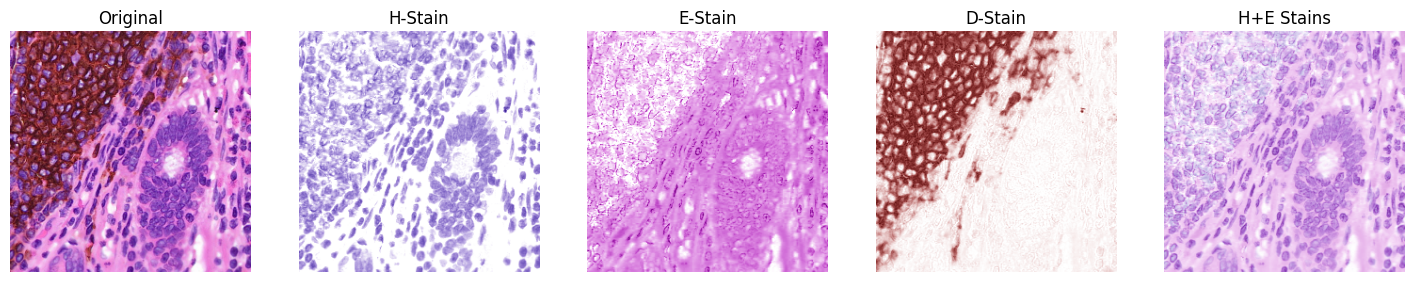

In [19]:
import matplotlib.pyplot as plt
import cv2

# Load your six stain-separated images
image0 = cv2.imread("/drive3/Anshuman/testing_project/vahadane/81_241-0_original.png")
image1 = cv2.imread("/drive3/Anshuman/testing_project/vahadane/81_241-3_Hstain.png")  # Load the H-stain image
image2 = cv2.imread("/drive3/Anshuman/testing_project/vahadane/81_241-1_Estain.png")  # Load the E-stain image
image3 = cv2.imread("/drive3/Anshuman/testing_project/vahadane/81_241-2_Dstain.png")  # Load the D-stain image

# Combine the H, E, and D-stain images
combined_HED = cv2.addWeighted(image1, 0.5, image2, 0.5, 0)  # Blend H and E
#combined_HED = cv2.addWeighted(combined_HED, 0.5, image3, 0.5, 0)  # Blend H+E and D

# Create a figure with six subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 12))

axes[0].imshow(cv2.cvtColor(image0, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")

# Display the H-stain image on the first subplot
axes[1].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[1].set_title("H-Stain")

# Display the E-stain image on the second subplot
axes[2].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[2].set_title("E-Stain")

# Display the D-stain image on the third subplot
axes[3].imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
axes[3].set_title("D-Stain")

# Display the H+E+D-stain image on the fourth subplot
axes[4].imshow(cv2.cvtColor(combined_HED, cv2.COLOR_BGR2RGB))
axes[4].set_title("H+E Stains")

# Hide the axes labels
for ax in axes:
    ax.axis('off')

# Show the figure
plt.show()